# Categorical variables, multicollinearity and biases

```{note}
Unless said otherwise, the examples and discussion for this chapter were taken from {cite}`mcelreath2018statistical`.
```

## Categorical variables

In the data of the !Kung population used in [Chapter 9](../Part4/09_ModelChecking), [Chapter 10](../Part4/10_BayesianRegression) and [Chapter 11](../Part4/11_ComputationalApproximations) we didn't consider the sex of the people when we model their height, even when we know that men and women tend to have a different average height. One way to incorporate this difference is with the model:

$$
\begin{align*}\
h_i|\mu_i,\sigma^2 &\sim \textsf{Normal}(\mu_i,\sigma^2) \\
\mu_i|\alpha,\beta_M &= \alpha + \beta_M M_i\\
\alpha &\sim \textsf{Normal}(167, 3^2) \\
\beta &\sim \textsf{Normal}(0, 3^2) \\
\sigma &\sim \textsf{Uniform}(0, 10),
\end{align*}
$$

where $M_i=1$ if the $i$-th person is male and zero if it is female.

In thus model $\beta_M$ represents the expected difference between the height of men and women. This also means that $\alpha$ is no longer the average height of the population, but women average height. This model assumes more prior uncertainty in the height of men than height of women. This is because the height of men includes two parameters, and thus, two priors. The next figure shows the prior distribution for the average height of mean and the average height of women. You can find the details in the code [22_HeightSex.ipynb](https://github.com/IrvingGomez/BayesianStatistics/blob/main/Codes/22_HeightSex.ipynb) in the [repository of the course](https://github.com/IrvingGomez/BayesianStatistics).

```{image} Images/PriorHeight.png
:alt: PriorHeight
:align: center
```

Another model that we can use is given by:

$$
\begin{align*}\
h_i|\mu_i,\sigma^2 &\sim \textsf{Normal}(\mu_i,\sigma^2) \\
\mu_i|\alpha_j &= \alpha_{\text{SEX}[i]}\\
\alpha_j &\sim \textsf{Normal}(167, 3^2),\quad j=1,2 \\
\sigma &\sim \textsf{Uniform}(0, 10).
\end{align*}
$$

In this case, the same prior distribution can be used for both sexes, so none of them has more prior uncertainty. The variable $\alpha_{\text{SEX}[i]}$ is usually referred as an index variable, since it has an index for each category of the variable. The next figure shows the posterior distribution of $\alpha_{\text{SEX}[i]}$, considering the adults of the !Kung population.

```{image} Images/PosteriorHeight.png
:alt: PosteriorHeight
:align: center
```

## Multicollinearity

The problem of multicollinearity refers to a strong association between two or more predictor variables. A consequence of multicollinearity is that the posterior distributions suggests that none of the predictor variables is associated with the variable of interest. Let's make a simulation to illustrate this problem.

Imagine trying to predict the height of a person using the length of the legs. Surely height is positively associated with leg length,
or at least our simulation will assume it is. Nevertheless, once you put both legs (right and left) into the model, something vexing will happen.

The code below simulates the height and leg lengths of `N` people. First, a height is simulated from a Gaussian distribution. Then each individual gets a simulated
proportion of height for their legs. Finally, each leg is salted with a little measurement or developmental error, so the left and right legs are not exactly the same
length.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

In [2]:
from scipy.stats import multivariate_normal, norm, uniform

In [3]:
ALPHA_LEVEL = 0.11

N = 100

Height   = norm.rvs(size=N, loc=170, scale=10)
LegProp  = uniform.rvs(size=N, loc=0.6, scale=0.1)
LegLeft  = LegProp * Height + norm.rvs(size=N, loc=0, scale=0.02)
LegRight = LegProp * Height + norm.rvs(size=N, loc=0, scale=0.02)

The slope of the next regression model measures the association of a leg with the height, so we expect it to be around $1/0.6\approx 1.67$.

$$
\begin{align*}
h_i|\mu_i,\sigma^2 &\sim \textsf{Normal}(\mu_i, \sigma^2) \\
\mu_i|\beta_L,\beta_R &= \beta_L x_{L,i} + \beta_R x_{R,i} \\
p(\beta_L,\beta_R,\sigma) &\propto 1_{\mathbb{R}}(\beta_L)1_{\mathbb{R}}(\beta_R)1_{(0,\infty)}(\sigma)
\end{align*}
$$

In [4]:
with pm.Model() as HeightLegModel:
    Beta   = pm.Flat('Beta', shape=2)
    Sigma  = pm.HalfFlat('Sigma')
    HeightModel = pm.Normal('Height', mu=Beta[0]*LegLeft + Beta[1]*LegRight, sigma=Sigma, observed=Height)
    
    MeanQ = pm.find_MAP()

with pm.Model() as HeightLegModel2:
    Beta   = pm.Flat('Beta', shape=2)
    Sigma  = pm.HalfFlat('Sigma')
    HeightModel = pm.Normal('Height', mu=Beta[0]*LegLeft + Beta[1]*LegRight, sigma=Sigma, observed=Height, transform=None)
    
    IFisher = pm.find_hessian(MeanQ, vars=[Beta, Sigma])

IFisherInverse = np.linalg.inv(IFisher)

In [5]:
PosteriorSample = multivariate_normal.rvs(
    size = 10**3,
    mean = np.concatenate((MeanQ['Beta'], [MeanQ['Sigma']])),
    cov = IFisherInverse
)

PosteriorSample = pd.DataFrame(PosteriorSample, columns=['BetaLeft', 'BetaRight', 'Sigma'])

The next table gives a summary of the posterior distribution. Note the bizarre behavior of $\beta_L$ and $\beta_R$, with extremely wide credible intervals.

In [6]:
PosteriorSample.describe(percentiles=[ALPHA_LEVEL/2, 1-ALPHA_LEVEL/2])

,BetaLeft,BetaRight,Sigma
count,1000.000000,1000.000000,1000.000000
mean,0.212014,1.320642,7.666061
std,27.485832,27.485622,0.068745
min,-87.412255,-78.456433,7.414876
5.5%,-42.192166,-42.554262,7.553123
50%,0.646005,0.891006,7.666054
94.5%,44.079838,43.721909,7.775633
max,79.990308,88.947810,7.858265


The posterior distribution of these two parameters is very highly correlated with all of the plausible values lying along a narrow ridge.

Text(0, 0.5, '$\\beta_R$')

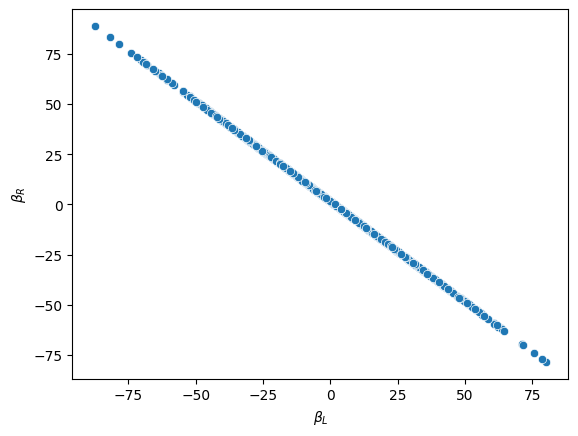

In [7]:
sns.scatterplot(data=PosteriorSample, x='BetaLeft', y='BetaRight')

plt.xlabel(r'$\beta_L$')
plt.ylabel(r'$\beta_R$')

One way to think of this phenomenon is that we have approximated this model:

$$
\begin{align*}
h_i|\mu_i,\sigma^2 &\sim \textsf{Normal}(\mu_i, \sigma^2) \\
\mu_i|\beta_L,\beta_R &= (\beta_L + \beta_R) x_i \\
p(\beta_L,\beta_R,\sigma) &\propto 1_{\mathbb{R}}(\beta_L)1_{\mathbb{R}}(\beta_R)1_{(0,\infty)}(\sigma)
\end{align*}
$$

The parameters $\beta_L$ and $\beta_R$ cannot be pulled apart, because they never separately influence the mean $\mu$. Only their sum, $\beta_L+\beta_R$, influences $\mu$. That make their sum close to the actual association of $x$ with $h$.

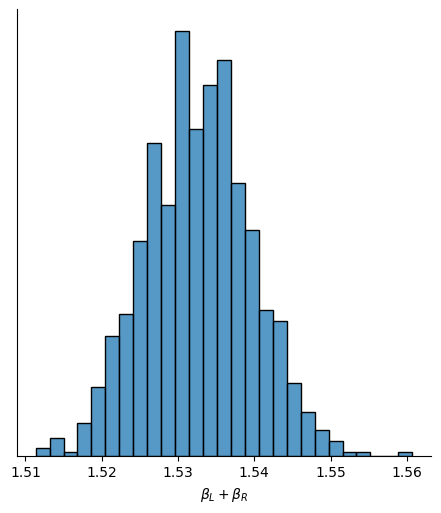

In [8]:
sns.displot(PosteriorSample['BetaLeft'] + PosteriorSample['BetaRight'])

_ = plt.xlabel(r'$\beta_L+\beta_R$')
_ = plt.yticks([])
_ = plt.ylabel('')

In this case, the problem is also fixed if we just consider the length of one leg instead of both of them.

In [9]:
with pm.Model() as HeightLegNoCollinearModel:
    Beta   = pm.Flat('Beta')
    Sigma  = pm.HalfFlat('Sigma')
    HeightModel = pm.Normal('Height', mu=Beta*LegLeft, sigma=Sigma, observed=Height)
    
    HeightLegNoCollinearTrace = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [10]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map = {"Beta": r"$\beta$", "Sigma": r"$\sigma$"})

/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': '$\\beta$'}>,
       <Axes: title={'center': '$\\sigma$'}>], dtype=object)

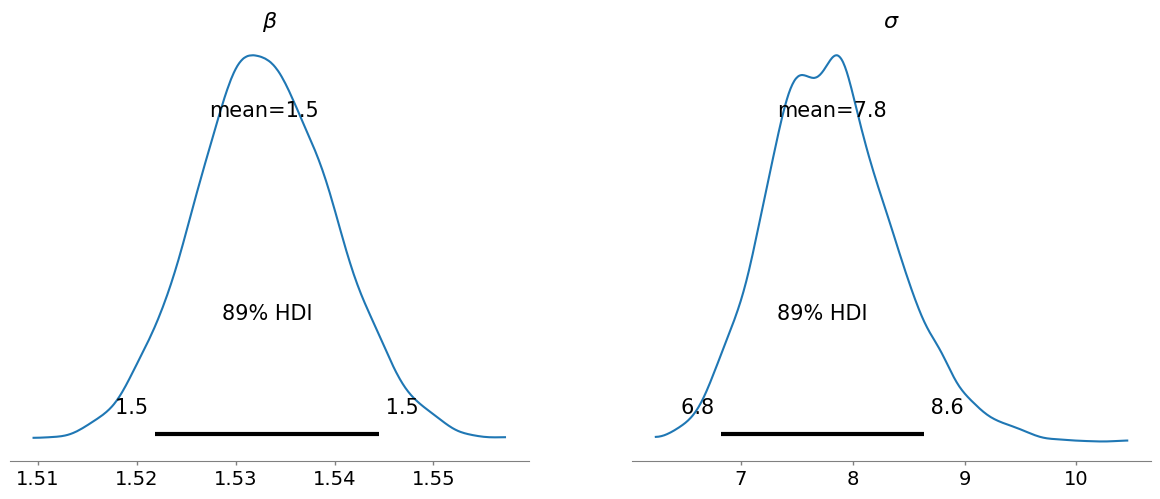

In [11]:
az.plot_posterior(HeightLegNoCollinearTrace, hdi_prob=1-ALPHA_LEVEL, labeller=labeller)

## Mediation or post-treatment bias

Suppose that we are growing some plants in a greenhouse. We want to know the effect of an antifungal treatment against a fungus that tends to reduce their growth. We measure the height of the plants, $H_0$, at an initial time. Then we apply the antifungal treatment, $T$, at random. Finally, after some time, we measure again the height of the plants and register the presence of the fungus. If our goal is to make a causal inference about the treatment, we shouldn’t include the fungus, because it is a post-treatment effect.

Let’s simulate some data, to make the example more transparent and see what exactly goes wrong when we include a post-treatment variable. Assume that when we take the first measurements, the plants' height was around 10cm, and we expect them to grow around 5cm if there is no presence of the fungus, but around 2cm in when there is fungus. Also, assume that the treatment reduces the probability of the fungus presence from 0.5 to 0.1.

In [12]:
from scipy.stats import bernoulli

In [13]:
N = 100

H0 = norm.rvs(size=N, loc=10, scale=2)

Treatment = np.array([0,1]*int(N/2))                    # We apply the threatment to half of the plants
Fungus    = bernoulli.rvs(size=N, p=0.5-Treatment*0.4)  # We simulate the presence of fungus
H1        = H0 + norm.rvs(size=N, loc=5-3*Fungus)       # We simulate the final height

First, let's calculate the growth proportion for plants with and without the treatment.

In [14]:
print(f"Average growth proportion for treater plants: {np.mean(H1[Treatment==1]/H0[Treatment==1]-1):.4f}")
print(f"Average growth proportion for not treater plants: {np.mean(H1[Treatment==0]/H0[Treatment==0]-1):.4f}")

Average growth proportion for treater plants: 0.4493
Average growth proportion for not treater plants: 0.3790


We can implement the next model:

$$
\begin{align*}
h_{1,i}|\mu_i,\sigma^2 &\sim \textsf{Normal}(\mu_i,\sigma^2) \\
\mu_i|p &= h_{0,i}\times p \\
p|\alpha,\beta_T,\beta_F &= \alpha + \beta_T T_i + \beta_F F_i \\
p(\alpha) &\propto 1_{(0,\infty)}(\alpha) \\
p(\beta_T) &\propto 1_{\mathbb{R}}(\beta_T) \\
p(\beta_F) &\propto 1_{\mathbb{R}}(\beta_F) \\
p(\sigma) &\propto 1_{(0,\infty)}(\sigma),
\end{align*}
$$

so $p$ is the proportion of growth.

In [15]:
with pm.Model() as FungusEffectModel:
    Alpha = pm.HalfFlat('Alpha')
    BetaT = pm.Flat('BetaT')
    BetaF = pm.Flat('BetaF')
    Sigma = pm.HalfFlat('Sigma')

    Proportion = Alpha + BetaT*Treatment + BetaF*Fungus

    Height = pm.Normal('Height', mu=H0*Proportion, sigma=Sigma, observed=H1)

    FungusEffectTrace = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Alpha, BetaT, BetaF, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


The next table shows a summary of the posterior of the parameters, note that $\beta_T$ is almost zero, implying that the treatment has no apparent effect on the growth of the plants. This is because the treatment just affects the plants growth through the development of the fungus. Thus, if we already know if there was presence of the fungus, knowing if the plant was treater is irrelevant. This type of relation is known as mediation, $T\rightarrow F\rightarrow H_1$.

In [16]:
az.summary(FungusEffectTrace, hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
BetaT,-0.054,0.031,-0.101,-0.003
BetaF,-0.274,0.035,-0.328,-0.216
Alpha,1.489,0.026,1.448,1.531
Sigma,1.370,0.098,1.221,1.527


The next causal Bayesian network illustrates our simulated data.

In [17]:
# The next libraries are to plot DAGs
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel

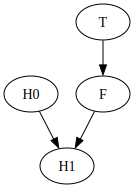

In [18]:
DagFungusEffect = CausalGraphicalModel(nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")])
DagFungusEffect.draw()

Using some rules known as **$d$-separation**, we can get all the relationships of independence implied in the DAG.

In [19]:
DagFungusEffect.get_all_independence_relationships()

[('H0', 'F', set()),
 ('H0', 'F', {'T'}),
 ('H0', 'T', set()),
 ('H0', 'T', {'F'}),
 ('H0', 'T', {'F', 'H1'}),
 ('T', 'H1', {'F'}),
 ('T', 'H1', {'F', 'H0'})]

One of the independence relationships is `('T', 'H1', {'F'})`, which means that conditional on $F$, $T$ and $H_1$ are independent, i.e. $H_1\perp\!\!\!\perp T|F$. Thus, if we want to estimate the effect of the treatment, we shouldn't include the presence of the fungus in the model.

In [20]:
with pm.Model() as FungusEffectModel2:
    Alpha = pm.HalfFlat('Alpha')
    BetaT = pm.Flat('BetaT')
    Sigma = pm.HalfFlat('Sigma')

    Proportion = Alpha + BetaT*Treatment

    Height = pm.Normal('Height', mu=H0*Proportion, sigma=Sigma, observed=H1)

    FungusEffectTrace2 = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Alpha, BetaT, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In the next table we can see the effect of the treatment in the height of the plants.

In [21]:
az.summary(FungusEffectTrace2, hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
BetaT,0.066,0.034,0.011,0.120
Alpha,1.354,0.024,1.313,1.390
Sigma,1.761,0.130,1.551,1.953


Conditioning on a post-treatment variable can not only fool you into thinking the treatment doesn’t work. It can also fool you into thinking it does work. Consider the next DAG:

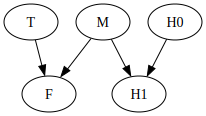

In [22]:
DagFungusNoEffect = CausalGraphicalModel(nodes=["H0", "H1", "F", "T", "M"], edges=[("H0", "H1"), ("M", "H1"), ("M", "F"), ("T", "F")])
DagFungusNoEffect.draw()

This graph represents the case in which the treatment $T$ influences the fungus $F$, but the fungus does not have an impact in the plants growth. The new variable $M$ is moisture, which influences both $H_1$ and $F$, but it's unobserved. Thus, the next DAG reflects better our case:

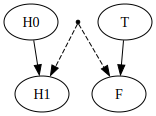

In [23]:
DagFungusNoEffect2 = CausalGraphicalModel(nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("T", "F")], latent_edges=[("F", "H1")])
DagFungusNoEffect2.draw()

The next cell shows all the independence relationships induced by the DAG.

In [24]:
DagFungusNoEffect2.get_all_independence_relationships()

[('H0', 'F', set()),
 ('H0', 'F', {'T'}),
 ('H0', 'T', set()),
 ('H0', 'T', {'F'}),
 ('H0', 'T', {'H1'}),
 ('T', 'H1', set()),
 ('T', 'H1', {'H0'})]

Note that among other independence relationships we have `('T', 'H1', set())`, which means that a regression of $H_1$ in $T$ would not reflect anything. However, if we condition on $F$, we don't have anymore the independence relation between $T$ and $H_1$. Let's illustrate this phenomenon through simulated data.

In [25]:
N = 100

H0 = norm.rvs(size=N, loc=10, scale=2)

Treatment = np.array([0,1]*int(N/2))                                 # We apply the threatment to half of the plants
Moist     = bernoulli.rvs(size=N, p=0.5)                             # We simulate the presence of moist
Fungus    = bernoulli.rvs(size=N, p=0.5 - 0.4*Treatment + 0.4*Moist) # We simulate the presence of fungus
H1        = H0 + norm.rvs(size=N, loc=5 + 3*Moist)                   # We simulate the final height

In [26]:
with pm.Model() as FungusNoEffectModel:
    Alpha = pm.HalfFlat('Alpha')
    BetaT = pm.Flat('BetaT')
    BetaF = pm.Flat('BetaF')
    Sigma = pm.HalfFlat('Sigma')

    Proportion = Alpha + BetaT*Treatment + BetaF*Fungus

    Height = pm.Normal('Height', mu=H0*Proportion, sigma=Sigma, observed=H1)

    FungusNoEffectTrace = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Alpha, BetaT, BetaF, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [27]:
az.summary(FungusNoEffectTrace, hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
BetaT,0.055,0.049,-0.025,0.131
BetaF,0.142,0.049,0.059,0.216
Alpha,1.532,0.048,1.454,1.605
Sigma,2.237,0.166,1.952,2.474


In the next model we do not cosider the fungus variable.

In [28]:
with pm.Model() as FungusNoEffectModel2:
    Alpha = pm.HalfFlat('Alpha')
    BetaT = pm.Flat('BetaT')
    Sigma = pm.HalfFlat('Sigma')

    Proportion = Alpha + BetaT*Treatment

    Height = pm.Normal('Height', mu=H0*Proportion, sigma=Sigma, observed=H1)

    FungusNoEffectTrace2 = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Alpha, BetaT, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [29]:
az.summary(FungusNoEffectTrace2, hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
BetaT,-0.006,0.045,-0.078,0.063
Alpha,1.639,0.032,1.590,1.689
Sigma,2.319,0.166,2.049,2.568


## Collider bias

```{Note}
The example for this section was taken from {cite}`pearl2018book`
```

Both talent and beauty contribute to a Hollywood actor’s success, but beauty and talent are completely unrelated to one another in the general population. This relation is represented in the next DAG:

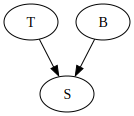

In [30]:
DagBeautyTalent = CausalGraphicalModel(nodes=["B", "T", "S"], edges=[("B", "S"), ("T", "S")])
DagBeautyTalent.draw()

Meanwhile $T$ and $B$ are independent, when we condition on $S$, a dependence is created. For example, if we look only at famous actors (in other words, we observe the variable $S=1$), we will see a negative correlation between talent and beauty: finding out that a celebrity is unattractive increases our belief that he or she is talented.

This phenomenon is known long ago, sometimes called Berkson's paradox. In 1946, Joseph Berkson, a biostatistician at the Mayo Clinic, pointed out a peculiarity of observational studies conducted in a hospital setting: even if two diseases have no relation to each other in the general population, they can appear to be associated among patients in a hospital. Actually, it is pretty common phenomenon:

- When there is an incomptent person in a directive position, we tend to justify its position by the contacts of the person. Meanwhile, a person without such contacts, can achieve a directive position due to their high competence.
- Many restaurants in good places tend to have terrible food. This is because the only way to keep such restaurants on float is if they are in a good place. On the other hand, excellent restaurants might be on float even if they are not located in the principal places of a city.

## Common cause bias

```{Note}
The example for this section was taken from {cite}`pearl2018book`
```

Consider the next DAG:

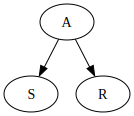

In [31]:
DagShoesReading = CausalGraphicalModel(nodes=["A", "S", "R"], edges=[("A", "S"), ("A", "R")])
DagShoesReading.draw()

This graph represents the relation between the shoe size of children, $S$, and their reading skill $R$. We will find that children with larger shoes tend to read better. But the relation is not of cause and effect. Giving a child larger shoes won’t make him read better! Instead, both variables are explained by a third, which is the child’s age. Older children have larger shoes, and they also are more advanced readers. We can eliminate this spurious correlation, by conditioning on the child’s age. For instance, if we look only at seven-year-olds, we expect to see no relationship between shoe size and reading ability.